In [36]:
#!/usr/bin/python
#import nltk
import numpy as np
import pandas as pd
import spacy
import itertools
import nltk
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import re

#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Lemmatization
from es_lemmatizer import lemmatize

from sklearn.model_selection import train_test_split
#from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
#import random
#from nltk.stem.wordnet import WordNetLemmatizer

# Models
import torch.nn as nn
#import torch.nn.functional as F

# Métricas
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [37]:
#import nltk
#nltk.download('punkt')

### Loading and Analyzing the data

In [38]:
#dtf = pd.read_csv('sdata/lc_denigracion.csv', encoding = 'cp1252')
#dtf = pd.read_csv('sdata/lc_exclusion.csv', encoding = 'cp1252')
#dtf = pd.read_csv('sdata/lc_general.csv', encoding = 'cp1252')
dtf = pd.read_csv('rand_sglobal.csv', encoding = 'cp1252')

In [39]:
dtf.head()

,clases,comentarios
0,denigracion,"Muy despreciados,siiii,pero todos vestidos de ..."
1,denigracion,marica explicame porque a veces no te entiendo...
2,denigracion,Es ridículo ayer le dije a un árabe que no era...
3,denigracion,@SuperFalete jajajajaja. Te jodes maricon.
4,denigracion,Rovira lleva siendo subnormal desde 1980.


In [40]:
#df = pd.concat([dt_train, dt_test])
#df.shape
dtf.shape

(2120, 2)

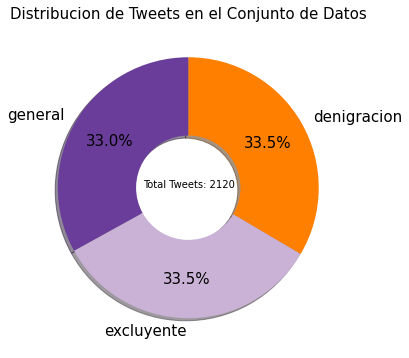

In [41]:
plt.figure(figsize = (6,6))
sorted_counts = dtf['clases'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(dtf.shape[0]))
plt.title('Distribucion de Tweets en el Conjunto de Datos', fontsize = 15);

### PRE-PROCESSING

In [42]:
data_dt = dtf.clases
dtf_class = data_dt.replace(to_replace='denigracion',value=0,regex=True)
dtf_class = dtf_class.replace(to_replace='excluyente',value=1,regex=True)
dtf_class = dtf_class.replace(to_replace='general',value=2,regex=True)

In [43]:
def Lemmatization(sentence):
    token_words = sp(sentence)
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(word.lemma_)
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

In [44]:
#Cleanning Sentences 
sp = spacy.load("es_core_news_sm")
sp.add_pipe(lemmatize, after="tagger")

def clean_text(text, remove_stopwords=False):
    '''Clean the text, with the option to remove stopwords'''
    #Remove @user or http://...
    text = re.sub(r"(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text) 

    # Translate OMG to Oh My God
    #text = translator(text)

    # Convert words to lower case and split them
    text = text.lower()#.split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("spanish"))
        text = [w for w in text if not w in stops]
    #text = " ".join(text)
    
    # Clean the text
    text = re.sub(r"<br />", " ", text)
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    #Lematize && itertools Ejmp: looove to love
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    text = Lemmatization(text)
    #print(text)
    # Return a list of words
    return(text)


Xdt_clean = []
for sentence in dtf.comentarios:
    Xdt_clean.append(clean_text(sentence))

In [45]:
# Check the cleaned comments
for i in range(2):
    print(Xdt_clean[i])

muy despreciados sii pero todo vestidos de alto costura espa ola o extranjero como el derechona burguÃ©s verdad 
marica explicame porque a veces no te entender en vez de venir a ensuciar mi cc con insulto homof 


In [46]:
dt_comments = np.array(Xdt_clean)
dt_comments = dt_comments.reshape(-1, 1)
dt_class = dtf_class.to_numpy() #antes de convertir las clases a valores numericos(0,1,2)
dt_class = dt_class.reshape(-1, 1)
data = np.concatenate((dt_class, dt_comments), axis=1)

Total and average number of words in each sentences

In [47]:
def maximum(sent):
    numb_words = []
    for s in sent:
        counter = len(s)
        numb_words.append(counter) 
    max_lengh = int(sum(numb_words)/len(numb_words))
    #print("Average: ", max_lengh)
    return numb_words,max_lengh
numb_words, max_seq_length = maximum(Xdt_clean)
print("Average: ", max_seq_length)

Average:  95


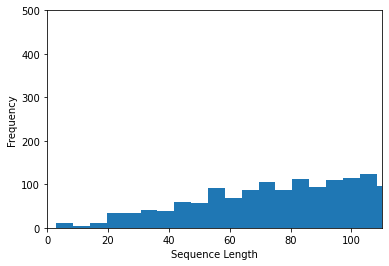

In [48]:
%matplotlib inline
def histograma(numb_words):
    plt.hist(numb_words, 50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.axis([0, 110, 0, 500])
    plt.show()
histograma(numb_words)

In [49]:
def text_tokenization(X_raw):
    # Tokenizes each sentence by implementing the nltk tool
    X_raw = [word_tokenize(x) for x in X_raw]
    return X_raw
comments = text_tokenization(Xdt_clean)
comments
#print(comments)

[['muy',
  'despreciados',
  'sii',
  'pero',
  'todo',
  'vestidos',
  'de',
  'alto',
  'costura',
  'espa',
  'ola',
  'o',
  'extranjero',
  'como',
  'el',
  'derechona',
  'burguÃ©s',
  'verdad'],
 ['marica',
  'explicame',
  'porque',
  'a',
  'veces',
  'no',
  'te',
  'entender',
  'en',
  'vez',
  'de',
  'venir',
  'a',
  'ensuciar',
  'mi',
  'cc',
  'con',
  'insulto',
  'homof'],
 ['ser',
  'rid',
  'culo',
  'ayer',
  'le',
  'decir',
  'a',
  'uno',
  'rabe',
  'que',
  'no',
  'ser',
  'necesario',
  'comer',
  'culo',
  'que',
  'no',
  'ir',
  'a',
  'discriminarle',
  'y',
  'me',
  'tachar',
  'de',
  'racista'],
 ['jajajajaja', 'te', 'joder', 'maricon'],
 ['rovira', 'llevar', 'ser', 'subnormal', 'desde'],
 ['buah',
  'yo',
  'no',
  'me',
  'har',
  'a',
  'nunca',
  'uno',
  'twitter',
  'ese',
  'est',
  'lleno',
  'de',
  'rojo',
  'de',
  'mierda'],
 ['joder',
  'que',
  'llegar',
  'uno',
  'punto',
  'en',
  'que',
  'alguien',
  'abrir',
  'el',
  'boca',
 

In [50]:
#numb_words = 1000
class Parameters:
    # Preprocessing parameeters
    numb_words = 1200
   
    # Model CNN parameters
    embedding_size: int = 64
    out_size: int = 32
    stride: int = 2
    # used with rnn
    conv_size    = (3, 3), #Size of the convolutions.
    conv_filters = 100, #Number of convolutions filters.
    pool_size    = (2, 2), #Size for the max pooling layer.
    pool_drop_rate = 0.4 #Drop rate of the max pooling layer.
   
    # Model BLSTM parameters
    input_size = 58
    dimension = 128
    #lstm_drop_rate = 0.5, #Drop rate after the lstm layer.
    
    # Training parameters
    epochs: int = 100
    batch_size: int = 12
    batch_size2: int = 12
    learning_rate: float = 0.001
        
    #embedding, #Numpy array representing the embedding.
    em_drop_rate = 0.5, #Drop rate after the embedding layer.   

In [51]:
def build_vocabulary(X_raw):
    # Builds the vocabulary and keeps the "x" most frequent words
    vocabulary = dict()
    fdist = nltk.FreqDist() 
    for sentence in X_raw:
        for word in sentence:
            fdist[word] += 1
  
    common_words = fdist.most_common(Parameters.numb_words)
    for idx, word in enumerate(common_words):
        vocabulary[word[0]] = (idx+1)        
    return vocabulary

#dmost_frequent = build_vocabulary(Xdt_clean) if use sentence.split()
dmost_frequent = build_vocabulary(comments)
#dmost_frequent

In [52]:
def word_to_idx(X_raw, vocabulary):    
    # By using the dictionary (vocabulary), it is transformed
    # each token into its index based representation	
    i_tokenized = list()
    for sentence in X_raw:
        temp_sentence = list()
        for word in sentence:
            if word in vocabulary.keys():
                temp_sentence.append(vocabulary[word])
        i_tokenized.append(temp_sentence)
        #print(x_tokenized)
    return i_tokenized

i_tokenized = word_to_idx(comments, dmost_frequent)
#print(i_tokenized)

In [53]:
def padding_sentences(idx_tokenized):
    # Each sentence which does not fulfill the required len
    # it's padded with the index 0
    pad_idx = 0
    X_padded = list()
    for sentence in idx_tokenized:
        while len(sentence) < max_seq_length:
            sentence.insert(len(sentence), pad_idx)
        X_padded.append(sentence)
    
    X_padded = np.array(X_padded)
    return X_padded

X_padded = padding_sentences(i_tokenized)
X_padded

array([[128,  12,  29, ...,   0,   0,   0],
       [ 55,   6, 321, ...,   0,   0,   0],
       [  2, 143,  63, ...,   0,   0,   0],
       ...,
       [ 15, 697,  51, ...,   0,   0,   0],
       [ 47, 229,   6, ...,   0,   0,   0],
       [  8, 225,  21, ...,   0,   0,   0]])

In [54]:
#X = data[:,1:]
y = data[:,:1]
y = y.astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
X_valid, y_valid = X_test, y_test
dic_data = {'X_train': X_train, 'y_train': y_train, 'X_test':X_test, 'y_test':y_test}
print(dic_data['X_train'])

[[  8   4 435 ...   0   0   0]
 [ 11 639  62 ...   0   0   0]
 [ 38   3 242 ...   0   0   0]
 ...
 [ 29  26 925 ...   0   0   0]
 [  8  56  67 ...   0   0   0]
 [ 14  79   6 ...   0   0   0]]


### MODELO

In [56]:
import math

#### CNN

In [57]:
class CNNText(nn.ModuleList):

    def __init__(self, args):
        super(CNNText, self).__init__()

        # Parameters regarding text preprocessing
        self.max_seq_len = max_seq_length
        self.numb_words = args.numb_words
        self.embedding_size = args.embedding_size

        # Dropout definition
        self.dropout = nn.Dropout(0.25)

        # CNN parameters definition
        # Kernel sizes
        self.kernel1 = 2
        self.kernel2 = 3
        self.kernel3 = 4
        self.kernel4 = 5

        # Output size for each convolution
        self.out_size = args.out_size
        # Number of strides for each convolution
        self.stride = args.stride

        # Embedding layer definition
        # Em+bedding(1001, 64, padding_idx=0)
        self.embedding = nn.Embedding(self.numb_words + 1, self.embedding_size, padding_idx=0)
        print('self.embedding')
        print(self.embedding)
        # Convolution layers definition
        self.conv1 = nn.Conv1d(self.max_seq_len, self.out_size, self.kernel1, self.stride)
        self.conv2 = nn.Conv1d(self.max_seq_len, self.out_size, self.kernel2, self.stride)
        self.conv3 = nn.Conv1d(self.max_seq_len, self.out_size, self.kernel3, self.stride)
        self.conv4 = nn.Conv1d(self.max_seq_len, self.out_size, self.kernel4, self.stride)

        # Max pooling layers definition
        self.pool1 = nn.MaxPool1d(self.kernel1, self.stride)
        self.pool2 = nn.MaxPool1d(self.kernel2, self.stride)
        self.pool3 = nn.MaxPool1d(self.kernel3, self.stride)
        self.pool4 = nn.MaxPool1d(self.kernel4, self.stride)

        # Fully connected layer definition
        self.fc = nn.Linear(self.in_features_fc(), 1)
            
    def in_features_fc(self):
        '''
        Calculates the number of output features after Convolution + Max pooling
         
        Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
        Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1   
        '''
        # Calcualte size of convolved/pooled features for convolution_1/max_pooling_1 features
        out_conv1 = ((self.embedding_size - 1 * (self.kernel1 - 1) - 1) / self.stride) + 1
        out_conv1 = math.floor(out_conv1)
        out_pool1 = ((out_conv1 - 1 * (self.kernel1 - 1) - 1) / self.stride) + 1
        out_pool1 = math.floor(out_pool1)
      
        # Calcualte size of convolved/pooled features for convolution_2/max_pooling_2 features
        out_conv2 = ((self.embedding_size - 1 * (self.kernel2 - 1) - 1) / self.stride) + 1
        out_conv2 = math.floor(out_conv2)
        out_pool2 = ((out_conv2 - 1 * (self.kernel2 - 1) - 1) / self.stride) + 1
        out_pool2 = math.floor(out_pool2)
      
        # Calcualte size of convolved/pooled features for convolution_3/max_pooling_3 features
        out_conv3 = ((self.embedding_size - 1 * (self.kernel3 - 1) - 1) / self.stride) + 1
        out_conv3 = math.floor(out_conv3)
        out_pool3 = ((out_conv3 - 1 * (self.kernel3 - 1) - 1) / self.stride) + 1
        out_pool3 = math.floor(out_pool3)
      
        # Calcualte size of convolved/pooled features for convolution_4/max_pooling_4 features
        out_conv4 = ((self.embedding_size - 1 * (self.kernel4 - 1) - 1) / self.stride) + 1
        out_conv4 = math.floor(out_conv4)
        out_pool4 = ((out_conv4 - 1 * (self.kernel4 - 1) - 1) / self.stride) + 1
        out_pool4 = math.floor(out_pool4)
      
        # Returns "flattened" vector (input for fully connected layer)
        return (out_pool1 + out_pool2 + out_pool3 + out_pool4) * self.out_size
    
    def forward(self, x):
        # Sequence of tokes is filterd through an embedding layer
        x = self.embedding(x)
      
        # Convolution layer 1 is applied
        x1 = self.conv1(x)
        x1 = torch.relu(x1)
        x1 = self.pool1(x1)
      
        # Convolution layer 2 is applied
        x2 = self.conv2(x)
        x2 = torch.relu((x2))
        x2 = self.pool2(x2)
   
        # Convolution layer 3 is applied
        x3 = self.conv3(x)
        x3 = torch.relu(x3)
        x3 = self.pool3(x3)
     
        # Convolution layer 4 is applied
        x4 = self.conv4(x)
        x4 = torch.relu(x4)
        x4 = self.pool4(x4)
      
        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3, x4), 2)
        
        # Comentar de aquí hacia abajo - MODIFICATION PARA usar con BLSTM
        union = union.reshape(union.size(0), -1)
        # The "flattened" vector is passed through a fully connected layer
        out = self.fc(union)
        
        # Dropout is applied
        out = self.dropout(out)
        
        # Activation function is applied
        out = torch.sigmoid(out)
        
        return out.squeeze()
        #return union

In [58]:
cnn_model = CNNText(Parameters)

self.embedding
Embedding(1201, 64, padding_idx=0)


In [59]:
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

from torch.utils.data import TensorDataset, Dataset, DataLoader
# Preliminaries
#from torchtext.data import Field, TabularDataset, BucketIterator
#from torchtext import datasets

class DatasetMaper(Dataset):
    def __init__(self, x, y):
        #self.transform = transforms.Compose([transforms.ToTensor(),transforms.ToTensor()])  # you can add to the list all the transformations you need.
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        #return self.transform(self.x[idx]), self.transform(self.y[idx])
        x = self.x[idx]
        y = self.y[idx]
        return x, y #torch.from_numpy(self.x[idx][0]), self.y[idx], self.x[idx][1]
    
class Run:
    '''Training, evaluation and metrics calculation'''

    @staticmethod
    def train(model, data, args):
        
        # Initialize dataset maper
        #train = DatasetMaper(data['X_train'], data['y_train'])
        #test = DatasetMaper(data['X_test'], data['y_test'])
        train = TensorDataset(torch.from_numpy(data['X_train']), torch.from_numpy(data['y_train']))
        test = TensorDataset(torch.from_numpy(data['X_test']), torch.from_numpy(data['y_test']))
        
        # Initialize loaders
        loader_train = DataLoader(train, batch_size=args.batch_size) # batch_size=10 
        loader_test = DataLoader(test, batch_size=args.batch_size)
        
        # Define optimizer
        optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

        # Starts training phase
        for epoch in range(args.epochs):
            # Set model in training model
            model.train()
            predictions = []
            # Starts batch training
            for x_batch, y_batch in loader_train:
                
                y_batch = y_batch.type(torch.FloatTensor)
                x_batch = x_batch.type(torch.LongTensor)  
                # Feed the model
                y_pred = model(x_batch)
                
                # Loss calculation
                loss = F.binary_cross_entropy(y_pred, y_batch)
              
                # Clean gradientes
                optimizer.zero_grad()

                # Gradients calculation
                loss.backward()

                # Gradients update
                optimizer.step()

                # Save predictions
                predictions += list(y_pred.detach().numpy())

            # Evaluation phase
            test_predictions = Run.evaluation(model, loader_test)

            # Metrics calculation
            train_accuary = Run.calculate_accuray(data['y_train'], predictions)
            test_accuracy = Run.calculate_accuray(data['y_test'], test_predictions)
            print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Test accuracy: %.5f" % (epoch+1, loss.item(), train_accuary, test_accuracy))

    @staticmethod
    def evaluation(model, loader_test):

        # Set the model in evaluation mode
        model.eval()
        predictions = []

        # Start evaluation phase
        with torch.no_grad():
            for x_batch, y_batch in loader_test:
                x_batch = x_batch.type(torch.LongTensor)
                y_pred = model(x_batch)
                predictions += list(y_pred.detach().numpy())
        return predictions

    @staticmethod
    def calculate_accuray(grand_truth, predictions):
        # Metrics calculation
        true_positives = 0
        true_negatives = 0
        for true, pred in zip(grand_truth, predictions):
            if (pred >= 0.5) and (true == 1):
                true_positives += 1
            elif (pred < 0.5) and (true == 0):
                true_negatives += 1
            else:
                pass
        # Return accuracy
        return (true_positives+true_negatives) / len(grand_truth)

In [60]:
# Training - Evaluation pipeline
Run().train(cnn_model, dic_data, Parameters)

<ipython-input-59-04ebca6d05fd>:58: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([12])) is deprecated. Please ensure they have the same size.
  loss = F.binary_cross_entropy(y_pred, y_batch)
<ipython-input-59-04ebca6d05fd>:58: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])) is deprecated. Please ensure they have the same size.
  loss = F.binary_cross_entropy(y_pred, y_batch)


Epoch: 1, loss: 0.95924, Train accuracy: 0.32724, Test accuracy: 0.36321
Epoch: 2, loss: -2.54382, Train accuracy: 0.32724, Test accuracy: 0.36085
Epoch: 3, loss: -6.78992, Train accuracy: 0.35083, Test accuracy: 0.37264
Epoch: 4, loss: -6.13169, Train accuracy: 0.39210, Test accuracy: 0.36557
Epoch: 5, loss: -6.90737, Train accuracy: 0.41922, Test accuracy: 0.36792
Epoch: 6, loss: -6.56118, Train accuracy: 0.44104, Test accuracy: 0.36792
Epoch: 7, loss: 0.17344, Train accuracy: 0.46993, Test accuracy: 0.37972
Epoch: 8, loss: 0.34658, Train accuracy: 0.47995, Test accuracy: 0.37972
Epoch: 9, loss: -6.90775, Train accuracy: 0.50354, Test accuracy: 0.38443
Epoch: 10, loss: -6.90772, Train accuracy: 0.50413, Test accuracy: 0.37736
Epoch: 11, loss: -6.73447, Train accuracy: 0.51238, Test accuracy: 0.37028
Epoch: 12, loss: -6.73446, Train accuracy: 0.52182, Test accuracy: 0.37028
Epoch: 13, loss: -6.73446, Train accuracy: 0.53774, Test accuracy: 0.37264
Epoch: 14, loss: -6.73445, Train accu

#### CNN + BLSTM

In [36]:
class CNNBLSTM(nn.Module):

    def __init__(self, args):
        super(CNNBLSTM, self).__init__()

        self.cnn = CNNText(args)
        self.lstm = nn.LSTM(input_size   = args.input_size, 
                            hidden_size  = args.dimension,
                            num_layers   = 1,
                            batch_first  = True,
                            bidirectional= True)
        #self.drop_rate = args.lstm_drop_rate
        self.drop = nn.Dropout(p = 0.5)
        self.dimension = args.dimension
        self.fc = nn.Linear(2*self.dimension, 1)

    def forward(self, text): #, text_len):
        cnn_out = self.cnn(text)
        #print('CNN: ')
        #print(cnn_out.size())
        
        lstm_out,_ = self.lstm(cnn_out)        
        #print('LSTM: ')
        #print(lstm_out.size())
        
        out = self.fc(lstm_out[:, -1, :])
        #print('fc: ', out.size())
        
        # Dropout is applied
        out = self.drop(out)
        #print('drop: ', out.size())
        #text_fea = torch.squeeze(text_fea, 1)
        
        # Activation function is applied
        out = torch.sigmoid(out)
        #print('sigmoid: ', out.size())
        
        #text_out = torch.sigmoid(text_fea)
        return out.squeeze()

In [107]:
cnn_blstm_model = CNNBLSTM(Parameters)

In [108]:
hloss_train = []
hloss_test = []
haccuracy_train = []
haccuracy_test = []
hepochs = []

In [109]:
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

from torch.utils.data import TensorDataset, Dataset, DataLoader
# Preliminaries
#from torchtext.data import Field, TabularDataset, BucketIterator
#from torchtext import datasets

class DatasetMaper(Dataset):
    def __init__(self, x, y):
        #self.transform = transforms.Compose([transforms.ToTensor(),transforms.ToTensor()])  # you can add to the list all the transformations you need.
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        #return self.transform(self.x[idx]), self.transform(self.y[idx])
        x = self.x[idx]
        y = self.y[idx]
        return x, y #torch.from_numpy(self.x[idx][0]), self.y[idx], self.x[idx][1]
    
class Run:
    '''Training, evaluation and metrics calculation'''
    # Metrics Presicion, recall and F1 measure
    val_precision = []
    val_recall = []
    val_f1 = []
        
    @staticmethod
    def train(model, data, args):
        
        # Initialize dataset maper
        train = DatasetMaper(data['X_train'], data['y_train'])
        test = DatasetMaper(data['X_test'], data['y_test'])
        
        #print('--------TRAIN--------')
        #print(train)
        # Initialize loaders
        loader_train = DataLoader(train, batch_size=args.batch_size)
        loader_test = DataLoader(test, batch_size=args.batch_size)
        
        # Define optimizer
        optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

        # Starts training phase
        for epoch in range(args.epochs):
            # Set model in training model
            model.train()
            predictions = []
            
            #Train Cycle
            with tqdm(total=len(X_train)) as pbar:
                # Starts batch training
                for x_batch, y_batch in loader_train:
                    y_batch = y_batch.type(torch.FloatTensor)
                    x_batch = x_batch.type(torch.LongTensor)  
                    # Feed the model
                    y_pred = model(x_batch)

                    # Loss calculation
                    loss = F.binary_cross_entropy(y_pred, y_batch)

                    # Clean gradientes
                    optimizer.zero_grad()

                    # Gradients calculation
                    loss.backward()

                    # Gradients update
                    optimizer.step()

                    # Save predictions
                    predictions += list(y_pred.detach().numpy())

            # Evaluation phase
            test_predictions = Run.evaluation(model, loader_test)

            # Metrics calculation
            train_accuary = Run.calculate_accuray(data['y_train'], predictions)
            test_accuracy = Run.calculate_accuray(data['y_test'], test_predictions)
            hloss_train.append(train_accuary)
            hloss_test.append(loss_predictions)
            haccuracy_train.append(loss)
            haccuracy_test.append(test_accuracy)
            hepochs.append(epoch)
            print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Test accuracy: %.5f" % (epoch+1, loss.item(), train_accuary, test_accuracy))

            if epoch > args.epochs - 2:
                #Train Cycle
                with tqdm(total=len(X_train)) as pbar:
                    for x_batch, y_batch in loader_train:
                        y_batch = y_batch.type(torch.FloatTensor)
                        x_batch = x_batch.type(torch.LongTensor)  

                        # Feed the model
                        y_pred = model(x_batch)
                        y_pred = y_pred.detach().numpy()

                        y_batch = y_batch.detach().numpy()
                        y_batch = np.reshape(y_batch, -1)

                        precision = precision_score(y_batch, y_pred, average=None)
                        recall = recall_score(y_batch, y_pred, average=None)
                        f1 = f1_score(y_batch, y_pred, average=None)

                        val_precision.append(precision)
                        val_recall.append(recall)
                        val_f1.append(f1)
                    
                # Average the accuracy of each epoch
                avg_precision = np.mean(val_precision)
                avg_recall = np.mean(val_recall)
                avg_f1 = np.mean(val_f1)
                
                print("Epoch: {}/{}".format(epoch, epochs),
                "Valid Precision: {:.3f}".format(avg_precision),
                "Valid Reca: {:.3f}".format(avg_recall),
                "Valid F1: {:.3f}".format(avg_f1))
                
                #class_names = ["Hapinnes","Sadness","Anger","Fear"]
                #class_names = ["Denigrante","Excluyente","General"]
                #print(classification_report(y_batch, y_pred, target_names=class_names))
                
                
                # Compute confusion matrix
                cnf_matrix = confusion_matrix(y_batch, y_pred)
                np.set_printoptions(precision=2)

                # Plot non-normalized confusion matrix
                plt.figure()
                plot_confusion_matrix(cnf_matrix, classes=class_names,
                                      title='Confusion matrix, without normalization')

                # Plot normalized confusion matrix
                plt.figure()
                plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                                      title='Normalized confusion matrix')

                plt.show()
                
    @staticmethod
    def evaluation(model, loader_test):

        # Set the model in evaluation mode
        model.eval()
        predictions = []

        # Start evaluation phase
        with torch.no_grad():
            for x_batch, y_batch in loader_test:
                x_batch = x_batch.type(torch.LongTensor)
                y_pred = model(x_batch)
                predictions += list(y_pred.detach().numpy())
        return predictions

    @staticmethod
    def calculate_accuray(grand_truth, predictions):
        # Metrics calculation
        true_positives = 0
        true_negatives = 0
        for true, pred in zip(grand_truth, predictions):
            if (pred >= 0.5) and (true == 1):
                true_positives += 1
            elif (pred < 0.5) and (true == 0):
                true_negatives += 1
            else:
                pass
        # Return accuracy
        return (true_positives+true_negatives) / len(grand_truth)


Training Model: ru=6,fcl=10,fcu=96


100%|██████████| 5681/5681 [00:05<00:00, 1247.26it/s]


Epoch: 0/150 Train Loss: 1.379 Train Acc: 0.311


100%|██████████| 5681/5681 [00:04<00:00, 1285.73it/s]


Epoch: 1/150 Train Loss: 1.375 Train Acc: 0.317


100%|██████████| 5681/5681 [00:05<00:00, 1194.51it/s]


Epoch: 2/150 Train Loss: 1.367 Train Acc: 0.326


100%|██████████| 5681/5681 [00:04<00:00, 1300.37it/s]


Epoch: 3/150 Train Loss: 1.329 Train Acc: 0.374


100%|██████████| 5681/5681 [00:04<00:00, 1297.95it/s]


Epoch: 4/150 Train Loss: 1.289 Train Acc: 0.404


100%|██████████| 5681/5681 [00:04<00:00, 1271.15it/s]


Epoch: 5/150 Train Loss: 1.260 Train Acc: 0.413


100%|██████████| 5681/5681 [00:04<00:00, 1319.95it/s]


Epoch: 6/150 Train Loss: 1.255 Train Acc: 0.416


100%|██████████| 5681/5681 [00:04<00:00, 1301.54it/s]


Epoch: 7/150 Train Loss: 1.239 Train Acc: 0.425


100%|██████████| 5681/5681 [00:04<00:00, 1298.17it/s]


Epoch: 8/150 Train Loss: 1.224 Train Acc: 0.428


100%|██████████| 5681/5681 [00:04<00:00, 1318.14it/s]


Epoch: 9/150 Train Loss: 1.201 Train Acc: 0.440


100%|██████████| 5681/5681 [00:04<00:00, 1307.81it/s]


Epoch: 10/150 Train Loss: 1.191 Train Acc: 0.442


100%|██████████| 5681/5681 [00:04<00:00, 1292.16it/s]


Epoch: 11/150 Train Loss: 1.180 Train Acc: 0.442


100%|██████████| 5681/5681 [00:04<00:00, 1314.24it/s]


Epoch: 12/150 Train Loss: 1.161 Train Acc: 0.451


100%|██████████| 5681/5681 [00:04<00:00, 1318.56it/s]


Epoch: 13/150 Train Loss: 1.155 Train Acc: 0.456


100%|██████████| 5681/5681 [00:04<00:00, 1265.59it/s]


Epoch: 14/150 Train Loss: 1.147 Train Acc: 0.456


100%|██████████| 5681/5681 [00:04<00:00, 1305.43it/s]


Epoch: 15/150 Train Loss: 1.123 Train Acc: 0.462


100%|██████████| 5681/5681 [00:04<00:00, 1325.93it/s]


Epoch: 16/150 Train Loss: 1.101 Train Acc: 0.467


100%|██████████| 5681/5681 [00:04<00:00, 1291.49it/s]


Epoch: 17/150 Train Loss: 1.086 Train Acc: 0.476


100%|██████████| 5681/5681 [00:04<00:00, 1308.27it/s]


Epoch: 18/150 Train Loss: 1.078 Train Acc: 0.480


100%|██████████| 5681/5681 [00:04<00:00, 1297.55it/s]


Epoch: 19/150 Train Loss: 1.082 Train Acc: 0.480


100%|██████████| 5681/5681 [00:04<00:00, 1323.88it/s]


Epoch: 20/150 Train Loss: 1.072 Train Acc: 0.499


100%|██████████| 5681/5681 [00:04<00:00, 1250.10it/s]


Epoch: 21/150 Train Loss: 1.068 Train Acc: 0.499


100%|██████████| 5681/5681 [00:04<00:00, 1322.58it/s]


Epoch: 22/150 Train Loss: 1.054 Train Acc: 0.503


100%|██████████| 5681/5681 [00:04<00:00, 1333.56it/s]


Epoch: 23/150 Train Loss: 1.029 Train Acc: 0.511


100%|██████████| 5681/5681 [00:04<00:00, 1324.63it/s]


Epoch: 24/150 Train Loss: 1.012 Train Acc: 0.523


100%|██████████| 5681/5681 [00:04<00:00, 1320.47it/s]


Epoch: 25/150 Train Loss: 0.993 Train Acc: 0.526


100%|██████████| 5681/5681 [00:04<00:00, 1304.47it/s]


Epoch: 26/150 Train Loss: 0.972 Train Acc: 0.534


100%|██████████| 5681/5681 [00:04<00:00, 1319.05it/s]


Epoch: 27/150 Train Loss: 0.970 Train Acc: 0.532


100%|██████████| 5681/5681 [00:04<00:00, 1273.53it/s]


Epoch: 28/150 Train Loss: 0.955 Train Acc: 0.545


100%|██████████| 5681/5681 [00:04<00:00, 1296.30it/s]


Epoch: 29/150 Train Loss: 0.941 Train Acc: 0.547


100%|██████████| 5681/5681 [00:04<00:00, 1317.97it/s]


Epoch: 30/150 Train Loss: 0.952 Train Acc: 0.542


100%|██████████| 5681/5681 [00:04<00:00, 1304.68it/s]


Epoch: 31/150 Train Loss: 0.927 Train Acc: 0.547


100%|██████████| 5681/5681 [00:04<00:00, 1309.78it/s]


Epoch: 32/150 Train Loss: 0.906 Train Acc: 0.555


100%|██████████| 5681/5681 [00:04<00:00, 1264.43it/s]


Epoch: 33/150 Train Loss: 0.921 Train Acc: 0.556


100%|██████████| 5681/5681 [00:04<00:00, 1283.04it/s]


Epoch: 34/150 Train Loss: 0.919 Train Acc: 0.557


100%|██████████| 5681/5681 [00:04<00:00, 1306.63it/s]


Epoch: 35/150 Train Loss: 0.917 Train Acc: 0.559


100%|██████████| 5681/5681 [00:04<00:00, 1272.26it/s]


Epoch: 36/150 Train Loss: 0.893 Train Acc: 0.575


100%|██████████| 5681/5681 [00:04<00:00, 1230.32it/s]


Epoch: 37/150 Train Loss: 0.886 Train Acc: 0.578


100%|██████████| 5681/5681 [00:04<00:00, 1307.76it/s]


Epoch: 38/150 Train Loss: 0.876 Train Acc: 0.581


100%|██████████| 5681/5681 [00:04<00:00, 1293.92it/s]


Epoch: 39/150 Train Loss: 0.877 Train Acc: 0.583


100%|██████████| 5681/5681 [00:04<00:00, 1277.98it/s]


Epoch: 40/150 Train Loss: 0.900 Train Acc: 0.568


100%|██████████| 5681/5681 [00:04<00:00, 1289.20it/s]


Epoch: 41/150 Train Loss: 0.867 Train Acc: 0.581


100%|██████████| 5681/5681 [00:04<00:00, 1286.69it/s]


Epoch: 42/150 Train Loss: 0.844 Train Acc: 0.598


100%|██████████| 5681/5681 [00:04<00:00, 1291.94it/s]


Epoch: 43/150 Train Loss: 0.825 Train Acc: 0.598


100%|██████████| 5681/5681 [00:04<00:00, 1222.05it/s]


Epoch: 44/150 Train Loss: 0.795 Train Acc: 0.616


100%|██████████| 5681/5681 [00:04<00:00, 1301.51it/s]


Epoch: 45/150 Train Loss: 0.794 Train Acc: 0.616


100%|██████████| 5681/5681 [00:04<00:00, 1329.44it/s]


Epoch: 46/150 Train Loss: 0.799 Train Acc: 0.612


100%|██████████| 5681/5681 [00:04<00:00, 1326.23it/s]


Epoch: 47/150 Train Loss: 0.812 Train Acc: 0.608


100%|██████████| 5681/5681 [00:04<00:00, 1328.22it/s]


Epoch: 48/150 Train Loss: 0.806 Train Acc: 0.617


100%|██████████| 5681/5681 [00:04<00:00, 1329.18it/s]


Epoch: 49/150 Train Loss: 0.823 Train Acc: 0.613


100%|██████████| 5681/5681 [00:04<00:00, 1324.40it/s]


Epoch: 50/150 Train Loss: 0.797 Train Acc: 0.613


100%|██████████| 5681/5681 [00:04<00:00, 1316.81it/s]


Epoch: 51/150 Train Loss: 0.800 Train Acc: 0.616


100%|██████████| 5681/5681 [00:04<00:00, 1306.41it/s]


Epoch: 52/150 Train Loss: 0.787 Train Acc: 0.620


100%|██████████| 5681/5681 [00:04<00:00, 1276.68it/s]


Epoch: 53/150 Train Loss: 0.762 Train Acc: 0.635


100%|██████████| 5681/5681 [00:04<00:00, 1328.16it/s]


Epoch: 54/150 Train Loss: 0.746 Train Acc: 0.639


100%|██████████| 5681/5681 [00:04<00:00, 1318.96it/s]


Epoch: 55/150 Train Loss: 0.757 Train Acc: 0.634


100%|██████████| 5681/5681 [00:04<00:00, 1257.87it/s]


Epoch: 56/150 Train Loss: 0.795 Train Acc: 0.626


100%|██████████| 5681/5681 [00:04<00:00, 1327.42it/s]


Epoch: 57/150 Train Loss: 0.799 Train Acc: 0.612


100%|██████████| 5681/5681 [00:04<00:00, 1323.88it/s]


Epoch: 58/150 Train Loss: 0.785 Train Acc: 0.628


100%|██████████| 5681/5681 [00:04<00:00, 1322.30it/s]


Epoch: 59/150 Train Loss: 0.759 Train Acc: 0.637


100%|██████████| 5681/5681 [00:04<00:00, 1249.42it/s]


Epoch: 60/150 Train Loss: 0.732 Train Acc: 0.652


100%|██████████| 5681/5681 [00:04<00:00, 1323.47it/s]


Epoch: 61/150 Train Loss: 0.730 Train Acc: 0.654


100%|██████████| 5681/5681 [00:04<00:00, 1335.41it/s]


Epoch: 62/150 Train Loss: 0.734 Train Acc: 0.653


100%|██████████| 5681/5681 [00:04<00:00, 1333.12it/s]


Epoch: 63/150 Train Loss: 0.725 Train Acc: 0.664


100%|██████████| 5681/5681 [00:04<00:00, 1339.44it/s]


Epoch: 64/150 Train Loss: 0.779 Train Acc: 0.627


100%|██████████| 5681/5681 [00:04<00:00, 1336.02it/s]


Epoch: 65/150 Train Loss: 0.861 Train Acc: 0.601


100%|██████████| 5681/5681 [00:04<00:00, 1320.41it/s]


Epoch: 66/150 Train Loss: 0.757 Train Acc: 0.645


100%|██████████| 5681/5681 [00:04<00:00, 1253.13it/s]


Epoch: 67/150 Train Loss: 0.709 Train Acc: 0.667


100%|██████████| 5681/5681 [00:04<00:00, 1327.47it/s]


Epoch: 68/150 Train Loss: 0.747 Train Acc: 0.649


100%|██████████| 5681/5681 [00:04<00:00, 1299.44it/s]


Epoch: 69/150 Train Loss: 0.730 Train Acc: 0.666


100%|██████████| 5681/5681 [00:04<00:00, 1318.38it/s]


Epoch: 70/150 Train Loss: 0.691 Train Acc: 0.696


100%|██████████| 5681/5681 [00:04<00:00, 1320.93it/s]


Epoch: 71/150 Train Loss: 0.652 Train Acc: 0.706


100%|██████████| 5681/5681 [00:04<00:00, 1306.90it/s]


Epoch: 72/150 Train Loss: 0.645 Train Acc: 0.712


100%|██████████| 5681/5681 [00:04<00:00, 1327.89it/s]


Epoch: 73/150 Train Loss: 0.635 Train Acc: 0.710


100%|██████████| 5681/5681 [00:04<00:00, 1259.24it/s]


Epoch: 74/150 Train Loss: 0.629 Train Acc: 0.721


100%|██████████| 5681/5681 [00:04<00:00, 1322.94it/s]


Epoch: 75/150 Train Loss: 0.626 Train Acc: 0.727


100%|██████████| 5681/5681 [00:04<00:00, 1298.08it/s]


Epoch: 76/150 Train Loss: 0.624 Train Acc: 0.725


100%|██████████| 5681/5681 [00:04<00:00, 1310.13it/s]


Epoch: 77/150 Train Loss: 0.642 Train Acc: 0.720


100%|██████████| 5681/5681 [00:04<00:00, 1318.97it/s]


Epoch: 78/150 Train Loss: 0.633 Train Acc: 0.718


100%|██████████| 5681/5681 [00:04<00:00, 1301.93it/s]


Epoch: 79/150 Train Loss: 0.658 Train Acc: 0.713


100%|██████████| 5681/5681 [00:04<00:00, 1326.11it/s]


Epoch: 80/150 Train Loss: 0.672 Train Acc: 0.711


100%|██████████| 5681/5681 [00:04<00:00, 1256.52it/s]


Epoch: 81/150 Train Loss: 0.668 Train Acc: 0.722


100%|██████████| 5681/5681 [00:04<00:00, 1304.24it/s]


Epoch: 82/150 Train Loss: 0.604 Train Acc: 0.748


100%|██████████| 5681/5681 [00:04<00:00, 1294.18it/s]


Epoch: 83/150 Train Loss: 0.569 Train Acc: 0.768


100%|██████████| 5681/5681 [00:04<00:00, 1299.48it/s]


Epoch: 84/150 Train Loss: 0.553 Train Acc: 0.774


100%|██████████| 5681/5681 [00:04<00:00, 1304.48it/s]


Epoch: 85/150 Train Loss: 0.539 Train Acc: 0.788


100%|██████████| 5681/5681 [00:04<00:00, 1264.33it/s]


Epoch: 86/150 Train Loss: 0.522 Train Acc: 0.796


100%|██████████| 5681/5681 [00:04<00:00, 1255.19it/s]


Epoch: 87/150 Train Loss: 0.519 Train Acc: 0.800


100%|██████████| 5681/5681 [00:04<00:00, 1219.64it/s]


Epoch: 88/150 Train Loss: 0.503 Train Acc: 0.808


100%|██████████| 5681/5681 [00:04<00:00, 1296.06it/s]


Epoch: 89/150 Train Loss: 0.510 Train Acc: 0.805


100%|██████████| 5681/5681 [00:04<00:00, 1293.60it/s]


Epoch: 90/150 Train Loss: 0.527 Train Acc: 0.797


100%|██████████| 5681/5681 [00:04<00:00, 1286.79it/s]


Epoch: 91/150 Train Loss: 0.508 Train Acc: 0.809


100%|██████████| 5681/5681 [00:04<00:00, 1307.41it/s]


Epoch: 92/150 Train Loss: 0.504 Train Acc: 0.808


100%|██████████| 5681/5681 [00:04<00:00, 1307.17it/s]


Epoch: 93/150 Train Loss: 0.488 Train Acc: 0.820


100%|██████████| 5681/5681 [00:04<00:00, 1327.50it/s]


Epoch: 94/150 Train Loss: 0.491 Train Acc: 0.813


100%|██████████| 5681/5681 [00:04<00:00, 1299.65it/s]


Epoch: 95/150 Train Loss: 0.477 Train Acc: 0.825


100%|██████████| 5681/5681 [00:04<00:00, 1320.52it/s]


Epoch: 96/150 Train Loss: 0.485 Train Acc: 0.812


100%|██████████| 5681/5681 [00:04<00:00, 1333.53it/s]


Epoch: 97/150 Train Loss: 0.479 Train Acc: 0.822


100%|██████████| 5681/5681 [00:04<00:00, 1341.29it/s]


Epoch: 98/150 Train Loss: 0.464 Train Acc: 0.832


100%|██████████| 5681/5681 [00:04<00:00, 1328.56it/s]


Epoch: 99/150 Train Loss: 0.468 Train Acc: 0.829


100%|██████████| 5681/5681 [00:04<00:00, 1297.82it/s]


Epoch: 100/150 Train Loss: 0.485 Train Acc: 0.824


100%|██████████| 5681/5681 [00:04<00:00, 1332.29it/s]


Epoch: 101/150 Train Loss: 0.443 Train Acc: 0.839


100%|██████████| 5681/5681 [00:04<00:00, 1267.03it/s]


Epoch: 102/150 Train Loss: 0.431 Train Acc: 0.848


100%|██████████| 5681/5681 [00:04<00:00, 1331.69it/s]


Epoch: 103/150 Train Loss: 0.413 Train Acc: 0.854


100%|██████████| 5681/5681 [00:04<00:00, 1287.07it/s]


Epoch: 104/150 Train Loss: 0.425 Train Acc: 0.852


100%|██████████| 5681/5681 [00:04<00:00, 1332.28it/s]


Epoch: 105/150 Train Loss: 0.411 Train Acc: 0.853


100%|██████████| 5681/5681 [00:04<00:00, 1327.16it/s]


Epoch: 106/150 Train Loss: 0.427 Train Acc: 0.850


100%|██████████| 5681/5681 [00:04<00:00, 1308.84it/s]


Epoch: 107/150 Train Loss: 0.423 Train Acc: 0.852


100%|██████████| 5681/5681 [00:04<00:00, 1327.32it/s]


Epoch: 108/150 Train Loss: 0.450 Train Acc: 0.833


100%|██████████| 5681/5681 [00:04<00:00, 1295.13it/s]


Epoch: 109/150 Train Loss: 0.456 Train Acc: 0.836


100%|██████████| 5681/5681 [00:04<00:00, 1323.05it/s]


Epoch: 110/150 Train Loss: 0.442 Train Acc: 0.842


100%|██████████| 5681/5681 [00:04<00:00, 1320.97it/s]


Epoch: 111/150 Train Loss: 0.466 Train Acc: 0.831


100%|██████████| 5681/5681 [00:04<00:00, 1336.13it/s]


Epoch: 112/150 Train Loss: 0.513 Train Acc: 0.805


100%|██████████| 5681/5681 [00:04<00:00, 1328.14it/s]


Epoch: 113/150 Train Loss: 0.534 Train Acc: 0.795


100%|██████████| 5681/5681 [00:04<00:00, 1305.79it/s]


Epoch: 114/150 Train Loss: 0.520 Train Acc: 0.811


100%|██████████| 5681/5681 [00:04<00:00, 1316.68it/s]


Epoch: 115/150 Train Loss: 0.414 Train Acc: 0.855


100%|██████████| 5681/5681 [00:04<00:00, 1282.79it/s]


Epoch: 116/150 Train Loss: 0.425 Train Acc: 0.847


100%|██████████| 5681/5681 [00:04<00:00, 1323.46it/s]


Epoch: 117/150 Train Loss: 0.397 Train Acc: 0.862


100%|██████████| 5681/5681 [00:04<00:00, 1341.57it/s]


Epoch: 118/150 Train Loss: 0.355 Train Acc: 0.877


100%|██████████| 5681/5681 [00:04<00:00, 1340.37it/s]


Epoch: 119/150 Train Loss: 0.353 Train Acc: 0.882


100%|██████████| 5681/5681 [00:04<00:00, 1327.88it/s]


Epoch: 120/150 Train Loss: 0.349 Train Acc: 0.889


100%|██████████| 5681/5681 [00:04<00:00, 1192.62it/s]


Epoch: 121/150 Train Loss: 0.336 Train Acc: 0.884


100%|██████████| 5681/5681 [00:04<00:00, 1323.57it/s]


Epoch: 122/150 Train Loss: 0.332 Train Acc: 0.886


100%|██████████| 5681/5681 [00:04<00:00, 1252.09it/s]


Epoch: 123/150 Train Loss: 0.357 Train Acc: 0.883


100%|██████████| 5681/5681 [00:04<00:00, 1310.46it/s]


Epoch: 124/150 Train Loss: 0.342 Train Acc: 0.888


100%|██████████| 5681/5681 [00:04<00:00, 1312.54it/s]


Epoch: 125/150 Train Loss: 0.337 Train Acc: 0.888


100%|██████████| 5681/5681 [00:04<00:00, 1342.95it/s]


Epoch: 126/150 Train Loss: 0.336 Train Acc: 0.884


100%|██████████| 5681/5681 [00:04<00:00, 1313.09it/s]


Epoch: 127/150 Train Loss: 0.340 Train Acc: 0.888


100%|██████████| 5681/5681 [00:04<00:00, 1297.54it/s]


Epoch: 128/150 Train Loss: 0.374 Train Acc: 0.872


100%|██████████| 5681/5681 [00:04<00:00, 1318.03it/s]


Epoch: 129/150 Train Loss: 0.347 Train Acc: 0.884


100%|██████████| 5681/5681 [00:04<00:00, 1240.74it/s]


Epoch: 130/150 Train Loss: 0.331 Train Acc: 0.892


100%|██████████| 5681/5681 [00:04<00:00, 1299.41it/s]


Epoch: 131/150 Train Loss: 0.296 Train Acc: 0.902


100%|██████████| 5681/5681 [00:04<00:00, 1297.08it/s]


Epoch: 132/150 Train Loss: 0.281 Train Acc: 0.912


100%|██████████| 5681/5681 [00:04<00:00, 1302.07it/s]


Epoch: 133/150 Train Loss: 0.266 Train Acc: 0.918


100%|██████████| 5681/5681 [00:04<00:00, 1295.62it/s]


Epoch: 134/150 Train Loss: 0.255 Train Acc: 0.922


100%|██████████| 5681/5681 [00:04<00:00, 1280.52it/s]


Epoch: 135/150 Train Loss: 0.254 Train Acc: 0.922


100%|██████████| 5681/5681 [00:04<00:00, 1290.16it/s]


Epoch: 136/150 Train Loss: 0.292 Train Acc: 0.902


100%|██████████| 5681/5681 [00:04<00:00, 1248.83it/s]


Epoch: 137/150 Train Loss: 0.324 Train Acc: 0.894


100%|██████████| 5681/5681 [00:04<00:00, 1310.06it/s]


Epoch: 138/150 Train Loss: 0.258 Train Acc: 0.916


100%|██████████| 5681/5681 [00:04<00:00, 1271.58it/s]


Epoch: 139/150 Train Loss: 0.283 Train Acc: 0.907


100%|██████████| 5681/5681 [00:04<00:00, 1325.32it/s]


Epoch: 140/150 Train Loss: 0.259 Train Acc: 0.919


100%|██████████| 5681/5681 [00:04<00:00, 1327.40it/s]


Epoch: 141/150 Train Loss: 0.296 Train Acc: 0.897


100%|██████████| 5681/5681 [00:04<00:00, 1331.74it/s]


Epoch: 142/150 Train Loss: 0.287 Train Acc: 0.904


100%|██████████| 5681/5681 [00:04<00:00, 1341.65it/s]


Epoch: 143/150 Train Loss: 0.311 Train Acc: 0.893


100%|██████████| 5681/5681 [00:04<00:00, 1273.85it/s]


Epoch: 144/150 Train Loss: 0.292 Train Acc: 0.904


100%|██████████| 5681/5681 [00:04<00:00, 1331.95it/s]


Epoch: 145/150 Train Loss: 0.338 Train Acc: 0.879


100%|██████████| 5681/5681 [00:04<00:00, 1331.67it/s]


Epoch: 146/150 Train Loss: 0.385 Train Acc: 0.858


100%|██████████| 5681/5681 [00:04<00:00, 1330.31it/s]


Epoch: 147/150 Train Loss: 0.428 Train Acc: 0.853


100%|██████████| 5681/5681 [00:04<00:00, 1343.90it/s]


Epoch: 148/150 Train Loss: 0.414 Train Acc: 0.861


 92%|█████████▏| 1311/1421 [00:02<00:00, 535.83it/s]


Epoch: 149/150 Train Loss: 0.319 Train Acc: 0.893 Valid Loss: 1.239 Valid Acc: 0.678 Valid Pre: 0.698 Valid Reca: 0.671 Valid F1: 0.679
             precision    recall  f1-score   support

   Hapinnes       0.78      0.75      0.76        95
    Sadness       0.65      0.58      0.61        97
      Anger       0.77      0.62      0.68       104
       Fear       0.58      0.72      0.64       141

avg / total       0.68      0.67      0.67       437

Confusion matrix, without normalization
[[ 71   7   3  14]
 [  6  56   1  34]
 [  6   7  64  27]
 [  8  16  15 102]]
Normalized confusion matrix
[[0.75 0.07 0.03 0.15]
 [0.06 0.58 0.01 0.35]
 [0.06 0.07 0.62 0.26]
 [0.06 0.11 0.11 0.72]]


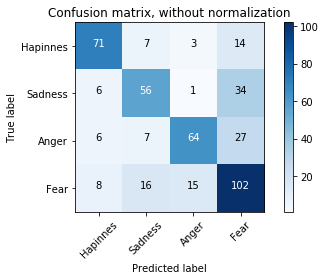

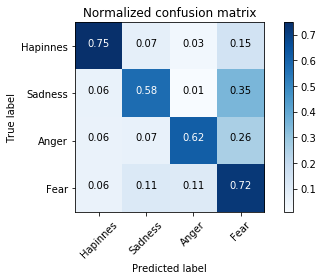

In [262]:
log_string = 'ru={},fcl={},fcu={}'.format(6,10,96)
model = CNNBLSTM(Parameters)       
train(model, epochs, log_string)

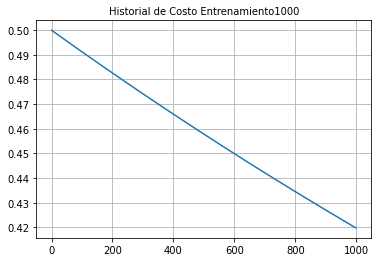

In [97]:
plt.plot(history_epochs, history_train_loss, 'b')
plt.title('Historial de Costo Entrenamiento1000')
plt.legend()

plt.show()

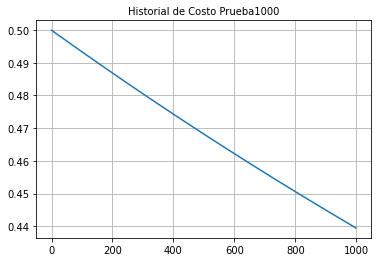

In [100]:
plt.plot(history_epochs, history_test_loss, 'b')
plt.title('Historial de Costo Prueba1000')
plt.legend()

plt.show()